In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
import re
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
torch.cuda.is_available()

False

In [4]:
import torch.multiprocessing as mp

if not mp.get_start_method(allow_none=True):
    mp.set_start_method('spawn')

In [5]:
df = pd.read_csv("recipe_gathered.csv")

In [6]:
df = df.drop('source', axis=1)

In [7]:
df.head()

,title,ingredients,directions,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [8]:
df.shape

(2231142, 4)

In [44]:
df_no_duplicates = df.drop_duplicates(subset='title', keep='first')

In [45]:
df_no_duplicates.shape

(1312871, 4)

## Cleaning Dataset

In [9]:
def find_problematic_row(df, column_name):
    problematic_rows = []
    for index, row in df.iterrows():
        try:
            eval(row[column_name])
        except Exception as e:
            problematic_rows.append((index, str(e)))
    return problematic_rows
# if cannot be iterrate, return row index
problematic_rows = find_problematic_row(df, 'ingredients')


In [10]:
problematic_row_indices = [row[0] for row in problematic_rows]

In [11]:
def replace_inner_quotes_split_method(s):
    # Split the string on commas to break it down into individual items
    items = s[2:-2].split('", "') # slice based on the 3rd character and 3rd last character
    # since they are " and "
    # Apply the replacement on each item
    items_modified = [item.replace('"', ' inch') for item in items]
    
    # Rejoin the modified items into a single string
    return '["' + '", "'.join(items_modified) + '"]'


df.loc[problematic_row_indices, 'ingredients'] = df.loc[problematic_row_indices, 'ingredients'].apply(replace_inner_quotes_split_method)

## Clean Up the steps

    -Specify chicken as an ingredient as there the instructions for the finetuned model not as optimized

In [12]:
target_ingredients = ["chicken"]

# Filter the DataFrame to include only recipes with the target ingredients
df_chicken = df[df['NER'].apply(lambda x: any(ingredient in x for ingredient in target_ingredients))].copy().reset_index()

In [13]:
df_chicken = df_chicken.drop('index', axis =1)

In [14]:
df_chicken.head()

,title,ingredients,directions,NER
0,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
1,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
2,Quick Barbecue Wings,"[""chicken wings (as many as you need for dinne...","[""Clean wings."", ""Flour and fry until done."", ...","[""chicken"", ""flour"", ""barbecue sauce""]"
3,Summer Chicken,"[""1 pkg. chicken cutlets"", ""1/2 c. oil"", ""1/3 ...","[""Double recipe for more chicken.""]","[""chicken cutlets"", ""oil"", ""red vinegar"", ""ore..."
4,Chicken Stew,"[""3 lb. chicken, boiled"", ""4 medium potatoes, ...","[""Remove chicken from bone."", ""Use the broth.""...","[""chicken"", ""potatoes"", ""onions"", ""corn"", ""Eng..."


In [15]:
df_chicken.shape

(256375, 4)

# EDA

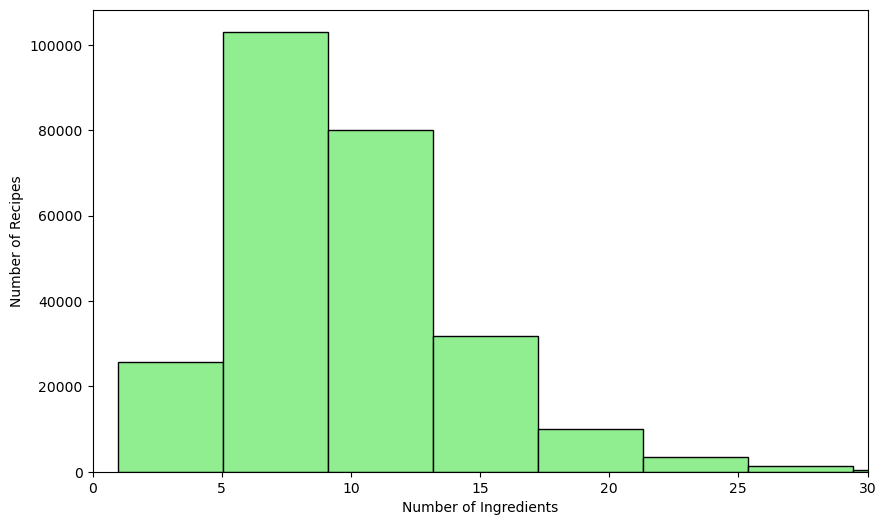

In [16]:
# Calculate the number of ingredients for each recipe
num_ingredients = df_chicken['ingredients'].apply(lambda x: len(eval(x)))

# Plot the distribution of the number of ingredients
plt.figure(figsize=(10, 6))
plt.hist(num_ingredients, bins=100, color='lightgreen', edgecolor='black')
#plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.xlim(0, 30) 
plt.show()

# majority of recipe contain 5 to 10 ingredients

In [17]:
df_chicken_10000 = df_chicken.sample(10000, random_state=42).reset_index()
df_chicken_10000 = df_chicken_10000.drop('index', axis =1)

In [56]:
df_chicken_10000.shape

(10000, 4)

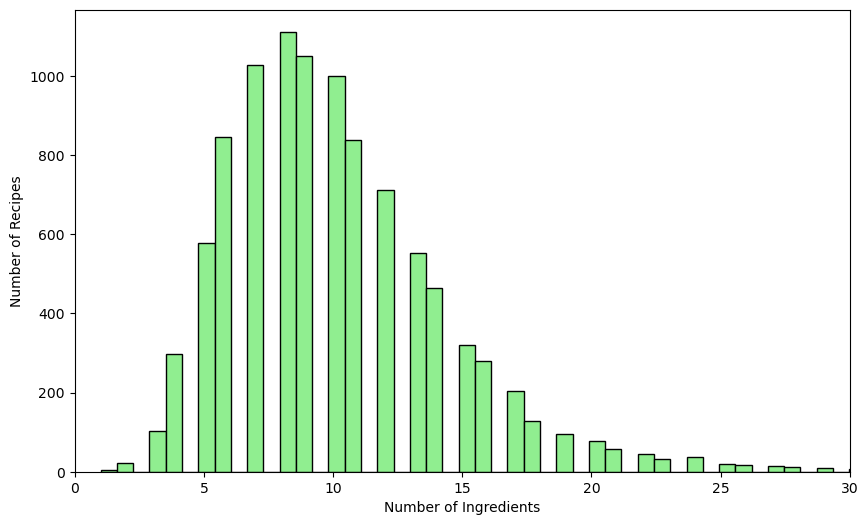

In [18]:
# Calculate the number of ingredients for each recipe
num_ingredients = df_chicken_10000['ingredients'].apply(lambda x: len(eval(x)))

# Plot the distribution of the number of ingredients
plt.figure(figsize=(10, 6))
plt.hist(num_ingredients, bins=100, color='lightgreen', edgecolor='black')
#plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.xlim(0, 30) 
plt.show()

# majority of recipe contain 5 to 10 ingredients

In [19]:
from ast import literal_eval
from collections import Counter

chicken_recipe_ingredients = []

# Step 1: Convert the string representation of lists to actual lists
chicken_recipe_ingredients = df_chicken_10000['NER'].apply(literal_eval)

# Step 2: Flatten the list of lists to get a single list containing all words
all_words = [word for sublist in chicken_recipe_ingredients for word in sublist]

# Step 3: Use a counter to get the count of each unique word
word_counts = Counter(all_words)
word_counts.most_common()

[('salt', 4237),
 ('chicken', 3962),
 ('garlic', 3295),
 ('onion', 3237),
 ('chicken broth', 2550),
 ('butter', 2293),
 ('chicken breasts', 1912),
 ('olive oil', 1570),
 ('pepper', 1478),
 ('water', 1467),
 ('flour', 1344),
 ('celery', 1270),
 ('cream of chicken soup', 1251),
 ('milk', 1223),
 ('tomatoes', 1154),
 ('parsley', 873),
 ('soy sauce', 852),
 ('sour cream', 842),
 ('onions', 777),
 ('lemon juice', 769),
 ('thyme', 755),
 ('mushrooms', 714),
 ('carrots', 696),
 ('chicken stock', 696),
 ('rice', 668),
 ('vegetable oil', 598),
 ('paprika', 570),
 ('eggs', 562),
 ('white wine', 552),
 ('black pepper', 537),
 ('mayonnaise', 535),
 ('margarine', 530),
 ('cream of mushroom soup', 521),
 ('Salt', 511),
 ('sugar', 505),
 ('oregano', 480),
 ('potatoes', 465),
 ('cornstarch', 459),
 ('red pepper', 444),
 ('green onions', 442),
 ('oil', 439),
 ('Cheddar cheese', 391),
 ('carrot', 386),
 ('egg', 385),
 ('Parmesan cheese', 375),
 ('green pepper', 371),
 ('bacon', 366),
 ('ground cumin', 3

In [20]:
my_dict = dict(sorted(word_counts.items(), key=lambda x: len(x[0])))

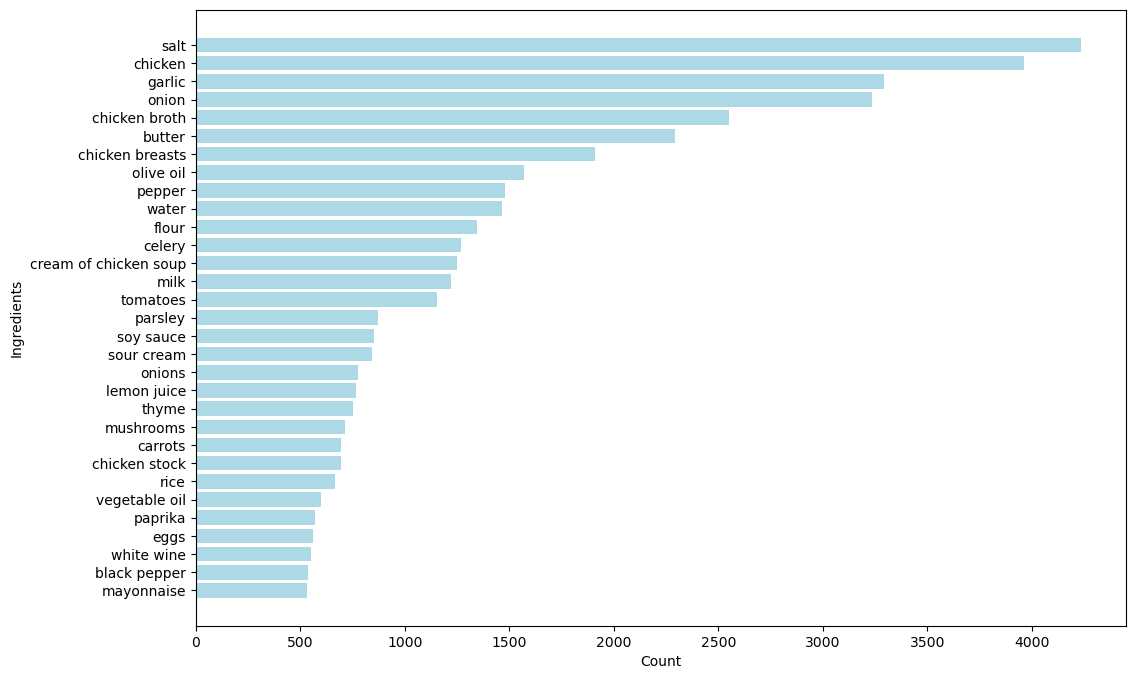

In [21]:
# Sort the dictionary by values in descending order
sorted_items = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)

top_30_keys = [item[0] for item in sorted_items[:31]]
top_30_values = [item[1] for item in sorted_items[:31]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_30_keys, top_30_values, color='lightblue')
plt.ylabel('Ingredients')
plt.xlabel('Count')
plt.gca().invert_yaxis()  # Display the most common ingredient at the top
plt.show()

In [60]:
def clean(text):
    
    if not isinstance(text, str):
        return text
    
    text = re.sub("\([^\)]*\)", " ", text)  # remove quotes
    text = re.sub(r'\{.*?\}', " ", text)    # remove curly brackets
    text = re.sub("(\s+|$\s+|\s+^)", " ", text)  # remove all additional white characters
    return text

# Apply the clean to the dataframe
df_chicken_10000_clean = df_chicken_10000.map(clean)

In [61]:
train_data = df_chicken_10000[:9900]
eval_data = df_chicken_10000[9900:]

In [62]:
train_data.shape, eval_data.shape

((9900, 4), (100, 4))

In [63]:
train_data.reset_index(drop=True, inplace=True)
eval_data.reset_index(drop=True, inplace=True)

In [64]:
train_data.shape, eval_data.shape

((9900, 4), (100, 4))

# Preparing the Training/Evaluation Data

In [65]:
import json

# taken from github with edits using except to locate problem rows
def df_to_json(input_df, output_file):
    print("Writing to", output_file)
    with open(output_file, 'w', encoding='utf-8') as f:
        for index, row in input_df.iterrows():
            try:
                if index%100000==0:
                    print(index)
                
                if type(row.NER)!=str:
                    continue

                title = row.title
                directions = json.loads(row.directions)
                ingredients = json.loads(row.ingredients)
                ner = json.loads(row.NER)
                
                res = "<RECIPE_START> <INPUT_START> " + " <NEXT_INPUT> ".join(ner) + " <INPUT_END> <INGR_START> " + \
                    " <NEXT_INGR> ".join(ingredients) + " <INGR_END> <INSTR_START> " + \
                    " <NEXT_INSTR> ".join(directions) + " <INSTR_END> <TITLE_START> " + title + " <TITLE_END> <RECIPE_END>"
                f.write("{}\n".format(res)) 
                
            except (UnicodeEncodeError, json.JSONDecodeError) as e:
                print("Error at row:", index)
                print("Error message:", e)
                print("Problematic column:", row.name)  # Get the column name with the maximum value
                print("Problematic data:", row)
                print("-" * 40)

In [66]:
df_to_json(train_data, 'new_train_chicken_10000')

Writing to new_train_chicken_10000
0


In [67]:
df_to_json(eval_data, 'new_eval_chicken_10000')

Writing to new_eval_chicken_10000
0


In [22]:
#pip install xformers

# Tokenization

In [68]:
# Set the seed for the model

import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed value to your desired number
set_seed(42)

In [69]:
import torch.multiprocessing as mp

if not mp.get_start_method(allow_none=True):
    mp.set_start_method('spawn')

In [70]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, Trainer, TrainingArguments, AdamW

# Step 1: Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
additional_special_tokens = [
    "<TITLE_START>", "<TITLE_END>", 
    "<INSTR_START>", "<NEXT_INSTR>", "<INSTR_END>", 
    "<INGR_START>", "<NEXT_INGR>", "<INGR_END>", 
    "<RECIPE_START>", "<RECIPE_END>", 
    "<INPUT_START>", "<INPUT_END>", "<NEXT_INPUT>"
]

# Step 2: Include the special tokens into tokenizer dict
special_tokens_dict = {'additional_special_tokens': additional_special_tokens, 'pad_token': "<RECIPE_END>"}
tokenizer.add_special_tokens(special_tokens_dict)

special_tokens_dict = {
    'additional_special_tokens': additional_special_tokens, 
    'pad_token': "<RECIPE_END>", 
    'bos_token': "", 
    'eos_token': "", 
    'unk_token': ""
}

tokenizer.add_special_tokens(special_tokens_dict)
# Step 3: Save the tokenizer to a directory
tokenizer.save_pretrained('path/to/save/tokenizer')

# Step 4: Check the saved special tokens map
import json
with open('path/to/save/tokenizer/special_tokens_map.json', 'r') as f:
    special_tokens_map = json.load(f)
    print(json.dumps(special_tokens_map, indent=4))

{
    "additional_special_tokens": [
        "<TITLE_START>",
        "<TITLE_END>",
        "<INSTR_START>",
        "<NEXT_INSTR>",
        "<INSTR_END>",
        "<INGR_START>",
        "<NEXT_INGR>",
        "<INGR_END>",
        "<RECIPE_START>",
        "<RECIPE_END>",
        "<INPUT_START>",
        "<INPUT_END>",
        "<NEXT_INPUT>"
    ],
    "pad_token": "<RECIPE_END>"
}


In [71]:
assert tokenizer.pad_token_id == tokenizer.convert_tokens_to_ids("<RECIPE_END>")

# Checking the training/eval data

In [72]:
with open('train_chicken_10000', 'r', encoding='utf-8') as f:
    train_chicken_10000 = f.readlines()

In [81]:
train_chicken_10000[:2]

['<RECIPE_START> <INPUT_START> chicken <NEXT_INPUT> apple <NEXT_INPUT> green onion <NEXT_INPUT> mayonnaise <NEXT_INPUT> lemon juice <NEXT_INPUT> curry powder <NEXT_INPUT> salt <NEXT_INPUT> bread <NEXT_INPUT> butter <INPUT_END> <INGR_START> 1 boneless chicken breast, skin removed <NEXT_INGR> 1/4 cup finely diced peeled apple <NEXT_INGR> 1 green onion, finely diced <NEXT_INGR> 1/4 cup mayonnaise <NEXT_INGR> 1 teaspoon lemon juice <NEXT_INGR> 1/4 teaspoon curry powder (optional) <NEXT_INGR> salt and pepper <NEXT_INGR> 6 slices bread <NEXT_INGR> 2 tablespoons butter, softened <INGR_END> <INSTR_START> Pour water in pan to 3/4 in and bring to simmer. <NEXT_INSTR> Add chicken , cover and poach over med/low heat for about 12 -15 minutes. <NEXT_INSTR> Put on a plate and refrigerate till cool enough to handle. Then finely dice. <NEXT_INSTR> In a bowl stir all remaining ingredients including the chicken. <NEXT_INSTR> Butter the bread with the softened butter and spread 1 slice with the mixture. T

In [75]:
# Remove '\n' characters from each line 
train_chicken = [line.strip().replace('\n', ' ') for line in train_chicken_10000]

In [76]:
len(train_chicken) # strange that there is an additional 173 recipes after reading the json file?

10173

In [82]:
with open('eval_chicken_10000', 'r', encoding='utf-8') as f:
    eval_chicken = f.readlines()
    
eval_chicken = [line.strip().replace('\n', ' ') for line in eval_chicken]

In [83]:
len(eval_chicken)

103

In [84]:
tokenized_recipes = tokenizer(train_chicken, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

# Display the shape of the tokenized data for verification
tokenized_recipes.input_ids.shape # 10043 recipes with 512 tokens padding with <RECIPE_END>

torch.Size([10173, 512])

In [85]:
tokenized_eval_recipes = tokenizer(eval_chicken, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

tokenized_eval_recipes.input_ids.shape

torch.Size([103, 512])

In [86]:
# Check that padding works
sample_recipe = tokenized_recipes["input_ids"][2] # 2nd recipe

# Decode the tokenized recipe back to text
decoded_recipe = tokenizer.decode(sample_recipe, skip_special_tokens=False)

# Print the decoded recipe
decoded_recipe

'<RECIPE_START> <INPUT_START> chicken breasts <NEXT_INPUT> onion <NEXT_INPUT> celery <NEXT_INPUT> garlic <NEXT_INPUT> whole black peppercorns <NEXT_INPUT> corn tortillas <NEXT_INPUT> vegetable oil <NEXT_INPUT> grated cheese <NEXT_INPUT> green chilies <NEXT_INPUT> light sour cream <NEXT_INPUT> green onions <NEXT_INPUT> cilantro leaf <NEXT_INPUT> clove garlic <INPUT_END> <INGR_START> 3 large boneless skinless chicken breasts <NEXT_INGR> 1 onion, chopped <NEXT_INGR> 2 celery ribs, chopped <NEXT_INGR> 2 cloves garlic, slice <NEXT_INGR> 2 teaspoons whole black peppercorns <NEXT_INGR> 6 corn tortillas, cut into 1 inch strips <NEXT_INGR> 2 tablespoons vegetable oil <NEXT_INGR> 2 cups grated cheese,, cheddar,jack or combination <NEXT_INGR> 1 (4 ounce) candiced roasted green chilies <NEXT_INGR> 1 cup light sour cream <NEXT_INGR> 3 green onions, thinly sliced <NEXT_INGR> 14 cup cilantro leaf, chopped <NEXT_INGR> 1 clove garlic, minced <INGR_END> <INSTR_START> Preheat oven to 350. <NEXT_INSTR> Pl

In [259]:
print(tokenizer.special_tokens_map)

# Model Fine-tuning 

In [87]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
# 50270 is the vocab size of gpt2-medium, 768 is the emdbedding of each token
model.resize_token_embeddings(len(tokenizer)) 

Embedding(50271, 768)

In [ ]:
# Training parameters

# Original

num_epochs = 3
batch_size = 4


model_name = "gpt2_finetuned_10000recipe_chicken"
training_args = TrainingArguments(output_dir = model_name, 
                                   learning_rate= 0.0003, # optimised lr based on trial & error
                                  num_train_epochs=num_epochs, # number of training epoch
                                   per_device_train_batch_size=batch_size,
                                   per_device_eval_batch_size=batch_size,
                                   weight_decay=0.01, # apply L2 regularization
                                   evaluation_strategy="epoch", # evaluate the model at the end of each epoch
                                   disable_tqdm=False, # progress bars will be shown during training, True = no show
                                  warmup_steps=500, # number of warmup steps for learning rate scheduler
                                   logging_steps=1000, # frequency of logging
                                  push_to_hub=True,
                                   log_level="error", # only errors will be logged, can set to levels - info, warning
                                    do_train=True,
                                    do_eval=True) 

In [88]:
# Training parameters

# 28 September 2023
# This is a new trial using training data/ eval data with no duplicate titles
# Performance was higher than df with duplicates

num_epochs = 3
batch_size = 4


model_name = "gpt2_finetuned_new_10000recipe_chicken"
training_args = TrainingArguments(output_dir = model_name, 
                                   learning_rate= 0.0003, # optimised lr based on trial & error
                                  num_train_epochs=num_epochs, # number of training epoch
                                   per_device_train_batch_size=batch_size,
                                   per_device_eval_batch_size=batch_size,
                                   weight_decay=0.01, # apply L2 regularization
                                   evaluation_strategy="epoch", # evaluate the model at the end of each epoch
                                   disable_tqdm=False, # progress bars will be shown during training, True = no show
                                  warmup_steps=500, # number of warmup steps for learning rate scheduler
                                   logging_steps=1000, # frequency of logging
                                  push_to_hub=True,
                                   log_level="error", # only errors will be logged, can set to levels - info, warning
                                    do_train=True,
                                    do_eval=True) 

In [89]:
# save the model in huggingface

from huggingface_hub import notebook_login

notebook_login()

In [90]:
from transformers import DataCollatorForLanguageModeling, Trainer

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_recipes["input_ids"],
    eval_dataset=tokenized_eval_recipes['input_ids']
)


trainer.train()

# The value below is a different model from presentation, it is a trial for any improvement

Cloning https://huggingface.co/JunF1122/gpt2_finetuned_new_10000recipe_chicken into local empty directory.
C:\Users\junfe\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.941400,1.819789
2,1.615400,1.705594
3,1.435100,1.676048


TrainOutput(global_step=7632, training_loss=1.8605120037086855, metrics={'train_runtime': 116924.6205, 'train_samples_per_second': 0.261, 'train_steps_per_second': 0.065, 'total_flos': 7974371524608000.0, 'train_loss': 1.8605120037086855, 'epoch': 3.0})

In [91]:
# push to HuggingFace Repository
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/475M [00:00<?, ?B/s]

Upload file runs/Sep28_20-40-05_JunFeng/events.out.tfevents.1695904855.JunFeng.27144.0:   0%|          | 1.00/…

To https://huggingface.co/JunF1122/gpt2_finetuned_new_10000recipe_chicken
   2761308..4caeee9  main -> main

To https://huggingface.co/JunF1122/gpt2_finetuned_new_10000recipe_chicken
   4caeee9..59fba67  main -> main



'https://huggingface.co/JunF1122/gpt2_finetuned_new_10000recipe_chicken/commit/4caeee975233d2785d85c90db885cbe2f87ccdbe'

In [92]:
# Remember to upload into HUggingFace Model card once Training is completed
tokenizer.save_pretrained("path/to/save/tokenizer")

('path/to/save/tokenizer\\tokenizer_config.json',
 'path/to/save/tokenizer\\special_tokens_map.json',
 'path/to/save/tokenizer\\vocab.json',
 'path/to/save/tokenizer\\merges.txt',
 'path/to/save/tokenizer\\added_tokens.json')

# Experimenting with learning rate

    - lowest validation loss should be preferred
    - Please do not run the code below
    - Results of learning rate experimentation
    - lr = 0.0003 has the lowest eval_loss

Evaluation loss (which is a measure of how well the model is predicting the next token in the sequence) is decreasing as the learning rate increases initially and reaches a minimum at a learning rate of 0.0003. After this point, increasing the learning rate further leads to an increase in the evaluation loss, indicating that a learning rate higher than 0.0003 is making the model perform worse on the validation dataset.

Hence we will use lr=0.0003 for our learning rate for the model

In [132]:
## 10 September 2023

# Training parameters
num_epochs = 3
batch_size = 4
learning_rates = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]

initial_model_path = "path/to/save/initial/model"
model.save_pretrained(initial_model_path)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False)

# Load your initial model
initial_model = model
evaluation_results = []


for lr in learning_rates:
    # Set the learning rate in the training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_lr_{lr}',
        learning_rate=lr,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01, # apply L2 regularization
        evaluation_strategy="epoch", # evaluate the model at the end of each epoch
        disable_tqdm=False, # progress bars will be shown during training, True = no show
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        logging_steps=200, # frequency of logging since 800/4 = 200
        push_to_hub=False, # as we are experimenting only push_to_hub for best lr
        log_level="error",
        do_train=True,
        do_eval=True)

    # Reset the model to its initial state
    model = GPT2LMHeadModel.from_pretrained(initial_model_path) # goes back to gpt2-small

    # Initialize the trainer with the current learning rate
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_recipes["input_ids"],
        eval_dataset=tokenized_eval_recipes['input_ids'],
        data_collator=data_collator,
    )
    
    # Train the model with the current learning rate
    trainer.train()
    
    # Evaluate the model on the validation dataset
    eval_results = trainer.evaluate(tokenized_eval_recipes['input_ids'])
    
    # Log the results
    evaluation_results.append((lr, eval_results))
    
    # Save the model
    model.save_pretrained(f'./models_lr_{lr}')

# Print or save the evaluation results to analyze later
for lr, eval_results in evaluation_results:
    print(f'Learning rate: {lr}, Eval results: {eval_results}') # lowest validation loss is the best usally

Epoch,Training Loss,Validation Loss
1,2.930200,2.764496
2,2.785500,2.638040
3,2.607000,2.505949


C:\Users\junfe\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.893700,2.669133
2,2.628000,2.430646
3,2.362600,2.288601


C:\Users\junfe\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.804200,2.469405
2,2.418000,2.263356
3,2.135100,2.112924


C:\Users\junfe\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.708700,2.379391
2,2.268600,2.227532
3,1.970100,2.052341


C:\Users\junfe\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.649500,2.481249
2,2.253500,2.343010
3,1.993300,2.136761


C:\Users\junfe\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.735500,2.636031
2,2.492200,2.734470
3,2.243700,2.368418


In [141]:
evaluation_results

[(1e-05,
  {'eval_loss': 2.505949020385742,
   'eval_runtime': 229.0087,
   'eval_samples_per_second': 0.873,
   'eval_steps_per_second': 0.218,
   'epoch': 3.0}),
 (3e-05,
  {'eval_loss': 2.2886009216308594,
   'eval_runtime': 262.5166,
   'eval_samples_per_second': 0.762,
   'eval_steps_per_second': 0.19,
   'epoch': 3.0}),
 (0.0001,
  {'eval_loss': 2.1129236221313477,
   'eval_runtime': 279.1143,
   'eval_samples_per_second': 0.717,
   'eval_steps_per_second': 0.179,
   'epoch': 3.0}),
 (0.0003,
  {'eval_loss': 2.0523412227630615,
   'eval_runtime': 297.3489,
   'eval_samples_per_second': 0.673,
   'eval_steps_per_second': 0.168,
   'epoch': 3.0}),
 (0.001,
  {'eval_loss': 2.136761426925659,
   'eval_runtime': 261.844,
   'eval_samples_per_second': 0.764,
   'eval_steps_per_second': 0.191,
   'epoch': 3.0}),
 (0.003,
  {'eval_loss': 2.368417739868164,
   'eval_runtime': 262.7606,
   'eval_samples_per_second': 0.761,
   'eval_steps_per_second': 0.19,
   'epoch': 3.0})]

In [168]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<RECIPE_END>',
 'additional_special_tokens': ['<TITLE_START>',
  '<TITLE_END>',
  '<INSTR_START>',
  '<NEXT_INSTR>',
  '<INSTR_END>',
  '<INGR_START>',
  '<NEXT_INGR>',
  '<INGR_END>',
  '<RECIPE_START>',
  '<RECIPE_END>',
  '<INPUT_START>',
  '<INPUT_END>',
  '<NEXT_INPUT>']}

# Load the trained Model from HuggingFace

In [179]:
# Remember to upload the tokenizer to hugging face

from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_hug = AutoTokenizer.from_pretrained("JunF1122/gpt2_finetuned_10000recipe_chicken")
model_hug = AutoModelForCausalLM.from_pretrained("JunF1122/gpt2_finetuned_10000recipe_chicken")

In [180]:
def prepare_input_text(ingredients_list):
    # Check the number of ingredients and handle more than 10
    if len(ingredients_list) > 10:
        ingredients_list = ingredients_list[:10]  # Truncate to the first 10 ingredients

    input_text = "<INPUT_START>"
    for ingredient in ingredients_list:
        input_text += f" {ingredient} <NEXT_INPUT>"
    input_text = input_text.rstrip(" <NEXT_INPUT>")  # Remove the last <NEXT_INPUT>
    input_text += " <INPUT_END><INGR_START>"  # Add the <INPUT_END><INSTR_START> tokens 
    return input_text

def input_ingredients():
    ingredients_list = []

    # Prompt the user for up to 10 ingredients
    for i in range(10):
        ingredient = input(f"Enter ingredient {i+1} (or 'stop' to finish): ").strip()
        if ingredient.lower() == 'stop':
            break
        ingredients_list.append(ingredient)

    # Call the previously defined prepare_input_text function with the list of ingredients
    return prepare_input_text(ingredients_list)

# Test the function by calling it
# You can enter up to 10 ingredients or type 'stop' to finish earlier
test_input = input_ingredients()
test_input

Enter ingredient 1 (or 'stop' to finish): chicken breast
Enter ingredient 2 (or 'stop' to finish): pepper
Enter ingredient 3 (or 'stop' to finish): salt
Enter ingredient 4 (or 'stop' to finish): oil
Enter ingredient 5 (or 'stop' to finish): garlic
Enter ingredient 6 (or 'stop' to finish): paprika
Enter ingredient 7 (or 'stop' to finish): onion
Enter ingredient 8 (or 'stop' to finish): brocolli
Enter ingredient 9 (or 'stop' to finish): stop


'<RECIPE_START> <INPUT_START> chicken breast <NEXT_INPUT> pepper <NEXT_INPUT> salt <NEXT_INPUT> oil <NEXT_INPUT> garlic <NEXT_INPUT> paprika <NEXT_INPUT> onion <NEXT_INPUT> brocolli <INPUT_END><INGR_START>'

temperature (float): Temperature controls the randomness of the generation. A higher temperature (e.g., 1.0) makes the output more random, while a lower temperature (e.g., 0.2) makes the output more deterministic and focused. Adjust this parameter based on the desired level of creativity in the generated text.

no_repeat_ngram_size (int): This parameter prevents the model from repeating n-grams in the generated text. For example, setting it to 3 ensures that no three consecutive words are repeated.

early_stopping (bool): If set to True, generation will stop when the model predicts the end of the sequence (based on eos_token_id).

# Generate the recipe

In [181]:
# Tokenize the input
input_sequence = tokenizer_hug.encode(test_input, return_tensors="pt")

# Generate the subsequent tokens using the model
generated_sequence = model_hug.generate(input_sequence, max_length=512, num_return_sequences=1, temperature=0.7,
                                        no_repeat_ngram_size=3, pad_token_id=50266) # token_id 50266 is <RECIPE_END>

# doing greedy search num_return_sequences must be 1

# Decode and display
generated_recipe = tokenizer_hug.decode(generated_sequence[0]) # Do not skip_special_tokens will use for post-processing
generated_recipe

"<RECIPE_START> <INPUT_START> chicken breast <NEXT_INPUT> pepper <NEXT_INPUT> salt <NEXT_INPUT> oil <NEXT_INPUT> garlic <NEXT_INPUT> paprika <NEXT_INPUT> onion <NEXT_INPUT> brocolli <INPUT_END><INGR_START>1 lb chicken breast, cut into bite sized pieces<NEXT_INGR>1/2 teaspoon pepper<NEXT_INGR>1 teaspoon salt<NEXT_INGR>1 tablespoon oil<NEXT_INGR>1 garlic clove, minced<NEXT_INGR>1 dash paprika<NEXT_INGR>1 onion, chopped<NEXT_INGR>1 lb brocollis, cut in half lengthwise and cut into 1/2 inch pieces<NEXT_INGR>2 cups frozen chopped spinach<INGR_END><INSTR_START>In a large skillet, brown chicken in oil over medium heat.<NEXT_INSTR>Add garlic and seasonings.<NEXT_INSTR>Cook until chicken is no longer pink.<NEXT_INSTR>Remove chicken from skillet and set aside.<NEXT_INSTR>In the same skillet, saute onion in oil until tender.<NEXT_INSTR>Stir in spinach.<NEXT_INSTR>Cover and cook over low heat for 5 minutes.<NEXT_INSTR>Serve over rice.<INSTR_END><TITLE_START>Chicken With Spinach And Brocolli<TITLE_

In [167]:
user_ingredients = generated_recipe.split("<INPUT_START>")[1].split("<INPUT_END>")[0].replace("<NEXT_INPUT>", ", ").strip()
recipe_ingredients = generated_recipe.split("<INGR_START>")[1].split("<INGR_END>")[0].replace("<NEXT_INGR>", "\n").strip()
instructions = generated_recipe.split("<INSTR_START>")[1].split("<INSTR_END>")[0].replace("<NEXT_INSTR>", "\n").strip()
title = generated_recipe.split("<TITLE_START>")[1].split("<TITLE_END>")[0].strip()


Interestingly, some generated recipes, the model will produce an additonal ingredient not stated in the input if max input is not entered.

# Use Fairprice online shopping prices to compile total cost

    - Format the recipe to a more user friendly style

In [168]:
fairprice_online = pd.read_csv('fairprice shopping list.csv')

In [169]:
fairprice_online.head()

,Ingredient,Name,Price,Quantity
0,salt,FairPrice Salt - Fine,0.25,250g
1,chicken,Sadia Frozen Whole Chicken Griller,5.40,800g
2,garlic,Chef China Old Garlic,1.90,200g
3,onion,Chef Yellow Onion - Large,1.93,700g
4,chicken broth,Heinz Packet Broth - Chicken,1.65,250ml


In [170]:
fairprice_online.dtypes

Ingredient     object
Name           object
Price         float64
Quantity       object
dtype: object

In [171]:
fairprice_online['Price'] = fairprice_online['Price'].astype('float')

In [172]:
user_ingredients

'chicken breast ,  pepper ,  salt ,  oil ,  garlic ,  paprika ,  onion ,  brocolli'

# Creating Recipe sheet

In [173]:
ingredient_list = [ingredient.strip() for ingredient in user_ingredients.split(',')]

In [174]:
ingredient_list

['chicken breast',
 'pepper',
 'salt',
 'oil',
 'garlic',
 'paprika',
 'onion',
 'brocolli']

In [175]:
matching_ingredients = fairprice_online[fairprice_online['Ingredient'].isin(ingredient_list)]

In [176]:
for index, row in matching_ingredients.iterrows():
    print(f'Ingredient: {row["Name"]}, Price: {row["Price"]}')
    
print()

total_price = matching_ingredients['Price'].sum()
print(f'Total price: ${round(total_price, 2)}')

Ingredient: FairPrice Salt - Fine, Price: 0.25
Ingredient: Chef China Old Garlic, Price: 1.9
Ingredient: Chef Yellow Onion - Large, Price: 1.93
Ingredient: Sadia Skinless Chicken Breast, Price: 8.23
Ingredient: GWS Black Pepper Ground (Bottle), Price: 6.0
Ingredient: MasterFoods Spices - Paprika Ground, Price: 4.44

Total price: $22.75


In [177]:
def recipe_sheet(generated_recipe):
    user_ingredients = generated_recipe.split("<INPUT_START>")[1].split("<INPUT_END>")[0].replace("<NEXT_INPUT>", ", ").strip()
    recipe_ingredients = generated_recipe.split("<INGR_START>")[1].split("<INGR_END>")[0].replace("<NEXT_INGR>", "\n").strip()
    instructions = generated_recipe.split("<INSTR_START>")[1].split("<INSTR_END>")[0].replace("<NEXT_INSTR>", "\n").strip()
    title = generated_recipe.split("<TITLE_START>")[1].split("<TITLE_END>")[0].strip()
    
    print(title)
    print('')
    print('Input')
    print(user_ingredients)
    print('')
    print('Ingredients')
    print(recipe_ingredients)
    print('')
    print('Directions')
    print(instructions)
    
    print('-' * 100)
    
    for index, row in matching_ingredients.iterrows():
        print(f'Ingredient: {row["Name"]}, Price: {row["Price"]}')
    
    print()

    total_price = matching_ingredients['Price'].sum()
    print(f'Total price: ${round(total_price, 2)}')

In [178]:
recipe_sheet(generated_recipe)

Chicken With Brocolli And Onions

Input
chicken breast ,  pepper ,  salt ,  oil ,  garlic ,  paprika ,  onion ,  brocolli

Ingredients
1 lb chicken breast
1/2 tsp pepper
1 tsp salt
1 tbsp oil
1 garlic clove
1 1/2 tbsp paprika
1 None onion, finely chopped
1 lb brocollini, cut into 1 inch pieces
None None Poultry seasoning

Directions
Preheat oven to 400°F. Line a baking tray with parchment paper.
Sprinkle chicken with pepper and salt. Heat oil in a large frying pan over medium heat. Cook chicken, turning once, until browned all over and cooked through, about 5 mins. Transfer to a plate.
Add garlic and onion to pan and cook, stirring, until fragrant, about 1 min. Add brocollis and cook until crisp-tender, about 3 mins. Add paprika and cook for 1 min, stirring.
Stir in onion and cook 1 min more. Add chicken and cook 2 mins, until cooked through.
Transfer to serving platter. Top with chicken and serve.
----------------------------------------------------------------------------------------

# Additonal Information 

# Evaluation of Generated Recipes and Standards using Same Ingredients (NER)

    - Using new model with no duplicated titles
    - Extra work not presented

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_new = AutoTokenizer.from_pretrained("JunF1122/gpt2_finetuned_new_10000recipe_chicken")
model_new = AutoModelForCausalLM.from_pretrained("JunF1122/gpt2_finetuned_new_10000recipe_chicken")

In [ ]:
def prepare_input_text(ingredients_list):
    # Check the number of ingredients and handle more than 10
    if len(ingredients_list) > 10:
        ingredients_list = ingredients_list[:10]  # Truncate to the first 10 ingredients

    input_text = "<RECIPE_START> <INPUT_START>"
    for ingredient in ingredients_list:
        input_text += f" {ingredient} <NEXT_INPUT>"
    input_text = input_text.rstrip(" <NEXT_INPUT>")  # Remove the last <NEXT_INPUT>
    input_text += " <INPUT_END><INGR_START>"  # Add the <INPUT_END><INSTR_START> tokens 
    return input_text

def input_ingredients():
    ingredients_list = []

    # Prompt the user for up to 10 ingredients
    for i in range(10):
        ingredient = input(f"Enter ingredient {i+1} (or 'stop' to finish): ").strip()
        if ingredient.lower() == 'stop':
            break
        ingredients_list.append(ingredient)

    # Call the previously defined prepare_input_text function with the list of ingredients
    return prepare_input_text(ingredients_list)

# Test the function by calling it
# You can enter up to 10 ingredients or type 'stop' to finish earlier
test_input = input_ingredients()
test_input

In [ ]:
# Tokenize the input
input_sequence = tokenizer_hug.encode(test_input, return_tensors="pt")

# Generate the subsequent tokens using the model
generated_sequence = model_hug.generate(input_sequence, max_length=512, num_return_sequences=1, temperature=0.7,
                                        no_repeat_ngram_size=3, pad_token_id=50266) # token_id 50266 is <RECIPE_END>

# doing greedy search num_return_sequences must be 1

# Decode and display
generated_recipe = tokenizer_hug.decode(generated_sequence[0]) # Do not skip_special_tokens will use for post-processing
generated_recipe

In [109]:
recipe_1 = generated_recipe_1.split("<TITLE_END>")[0] + "<TITLE_END>"

In [114]:
recipe_2 = generated_recipe_2.split("<TITLE_END>")[0] + "<TITLE_END>"

In [120]:
recipe_3 = generated_recipe_3.split("<TITLE_END>")[0] + "<TITLE_END>"

In [124]:
recipe_4 = generated_recipe_4.split("<TITLE_END>")[0] + "<TITLE_END>"

In [130]:
recipe_5 = generated_recipe_5.split("<TITLE_END>")[0] + "<TITLE_END>"

In [131]:
recipe_5

'<RECIPE_START> <INPUT_START> peene <NEXT_INPUT> chicken breasts <NEXT_INPUT> mustard <NEXT_INPUT> breadcrumbs <NEXT_INPUT> butter <NEXT_INPUT> onion <NEXT_INPUT> clove garlic <NEXT_INPUT> frozen spinach <NEXT_INPUT> cherry tomatoes <NEXT_INPUT> nutmeg <INPUT_END><INGR_START>1/2 cup peene or other shortening<NEXT_INGR>4 chicken breasts, skinned, boned and halved<NEXT_INGR>1/4 cup mustard<NEXT_INGR>1 cup breadcrumb<NEXT_INGR>1 tablespoon butter<NEXT_INGR>1 onion, chopped<NEXT_INGR>1 clove minced garlic<NEXT_INGR>1 (10 ounce) package frozen spinach, thawed and squeezed dry<NEXT_INGR>1 1/2 cups cherry tomatoes, halved and seeded<NEXT_INGR>1 teaspoon nutmeg<NEXT_INGR>1 -2 tablespoon grated Parmesan<INGR_END><INSTR_START>Preheat oven to 350 degrees F.<NEXT_INSTR>In a large bowl, combine peene, chicken, mustard, breadcrust, butter, onion, garlic, spinach, tomatoes, nutmeg, and grated cheese.<NEXT_INSTR>Spoon mixture into a greased 13x9-in. baking dish.<NEXT_INSTR>Bake, uncovered, for 30 minu

In [136]:
lst_gen = [recipe_1, recipe_2, recipe_3, recipe_4, recipe_5]

In [142]:
lst_gen

['<RECIPE_START> <INPUT_START> chicken breasts <NEXT_INPUT> sugar <NEXT_INPUT> soy sauce <NEXT_INPUT> cider vinegar <NEXT_INPUT> garlic <NEXT_INPUT> salt <INPUT_END><INGR_START>4 chicken breasts<NEXT_INGR>1/2 cup sugar<NEXT_INGR>1 tablespoon soy sauce<NEXT_INGR>1 teaspoon cider vinegar<NEXT_INGR>1 garlic clove, minced<NEXT_INGR>1 pinch salt<NEXT_INGR>1 cup shredded lettuce<INGR_END><INSTR_START>Preheat oven to 350 degrees.<NEXT_INSTR>Place chicken breasts in a baking dish.<NEXT_INSTR>Combine sugar, soy sauce, vinegar, garlic, salt and vinegar.<NEXT_INSTR>Pour over chicken.<NEXT_INSTR>Cover and bake for 30 minutes.<NEXT_INSTR>Remove chicken from oven and let stand for 5 minutes before serving.<INSTR_END><TITLE_START>Chicken Lettuce Salad<TITLE_END>',
 '<RECIPE_START> <INPUT_START> chicken breasts <NEXT_INPUT> sour cream <NEXT_INPUT> bacon <NEXT_INPUT> cream of mushroom soup <INPUT_END><INGR_START>4 chicken breasts<NEXT_INGR>1 c. sour cream<NEXT_INGR>1/2 c. bacon<NEXT_INGR>1 can cream of

In [140]:
!pip install jiwer

     ---------------------------------------- 1.8/1.8 MB 11.6 MB/s eta 0:00:00
     ---------------------------------------- 97.9/97.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4


In [141]:
import jiwer

In [148]:
with open('golden standard for comparison.txt', 'r', encoding='utf-8') as f:
    standard = f.readlines()
    
standard = [line.strip().replace('\n', ' ') for line in standard]

In [156]:
standard_sentences = standard
generated_sentences = lst_gen


wer_values = []
# Iterate through the lists and calculate WER for each pair
for reference, data in zip(standard_sentences, generated_sentences):
    wer = jiwer.wer(reference, data)
    wer_values.append(wer)

In [162]:
wer_values

[0.7674418604651163,
 0.8984375,
 0.7623762376237624,
 0.7655172413793103,
 0.803030303030303]

In [163]:
average_wer = sum(wer_values) / len(wer_values)

print(f"Average Word Error Rate:", {average_wer})

# 79.9% difference for generated recipes using the same NERs compared to recipes with the same NERs not in Training data

Average Word Error Rate: {0.7993606284996984}


## Original Source
    - My post-processing method no longer works well with the original research paper
    - May be due to the version incompatibility or even though I had prepared the post-processing in a similar function

In [151]:
from transformers import AutoTokenizer, AutoModelWithLMHead
tokenizer_nlg = AutoTokenizer.from_pretrained("mbien/recipenlg")
model_nlg = AutoModelForCausalLM.from_pretrained("mbien/recipenlg")

In [280]:
def prepare_input_text(ingredients_list):
    # Check the number of ingredients and handle more than 10
    if len(ingredients_list) > 10:
        ingredients_list = ingredients_list[:10]  # Truncate to the first 10 ingredients

    input_text = "<RECIPE_START> <INPUT_START>"
    for ingredient in ingredients_list:
        input_text += f" {ingredient} <NEXT_INPUT>"
    input_text = input_text.rstrip(" <NEXT_INPUT>")  # Remove the last <NEXT_INPUT>
    input_text += " <INPUT_END><INGR_START>"  # Add the <INPUT_END><INSTR_START> tokens 
    return input_text

def input_ingredients():
    ingredients_list = []

    # Prompt the user for up to 10 ingredients
    for i in range(10):
        ingredient = input(f"Enter ingredient {i+1} (or 'stop' to finish): ").strip()
        if ingredient.lower() == 'stop':
            break
        ingredients_list.append(ingredient)

    # Call the previously defined prepare_input_text function with the list of ingredients
    return prepare_input_text(ingredients_list)

# Test the function by calling it
# You can enter up to 10 ingredients or type 'stop' to finish earlier
test_input = input_ingredients()
test_input

Enter ingredient 1 (or 'stop' to finish): chicken
Enter ingredient 2 (or 'stop' to finish): red pepper
Enter ingredient 3 (or 'stop' to finish): salt
Enter ingredient 4 (or 'stop' to finish): garlic
Enter ingredient 5 (or 'stop' to finish): thyme


'<INPUT_START> chicken <NEXT_INPUT> red pepper <NEXT_INPUT> salt <NEXT_INPUT> garlic <NEXT_INPUT> thyme <INPUT_END><INGR_START>'

In [281]:
# Tokenize the input
input_sequence = tokenizer_hug.encode(test_input, return_tensors="pt")

# Generate the subsequent tokens using the model
generated_sequence = model_hug.generate(input_sequence, max_length=512, num_return_sequences=1, temperature=0.7,
                                        no_repeat_ngram_size=3, pad_token_id=50266) # token_id 50266 is <RECIPE_END>

# doing greedy search num_return_sequences must be 1

# Decode and display
generated_recipe = tokenizer_hug.decode(generated_sequence[0]) # Do not skip_special_tokens will use for post-processing
generated_recipe

In [282]:
generated_recipe

'<INPUT_START> chicken <NEXT_INPUT> red pepper <NEXT_INPUT> salt <NEXT_INPUT> garlic <NEXT_INPUT> thyme <INPUT_END><INGR_START> 1 chicken \t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t

In [ ]:
user_ingredients = generated_recipe.split("<INPUT_START>")[1].split("<INPUT_END>")[0].replace("<NEXT_INPUT>", ", ").strip()
recipe_ingredients = generated_recipe.split("<INGR_START>")[1].split("<INGR_END>")[0].replace("<NEXT_INGR>", "\n").strip()
instructions = generated_recipe.split("<INSTR_START>")[1].split("<INSTR_END>")[0].replace("<NEXT_INSTR>", "\n").strip()
title = generated_recipe.split("<TITLE_START>")[1].split("<TITLE_END>")[0].strip()

user_ingredients, recipe_ingredients, instructions, title